Results from SCARGC algorithm (for boxplot and accuracy timelime).
Two Rotating Gears (Two classes. Bidimensional).
Stream mode with pool size = 300



METHOD: Static lp as classifier
Execution time:  52.19108385185185
Average MCC:  0.866655173267
Average error: 7.1255
Average macro-F1: 0.9290096817806881
Average Accuracy:  92.8745
Standard Deviation:  0.878165559562
Variance:  0.77117475


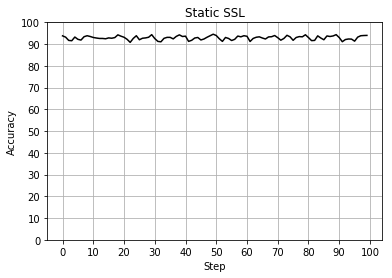

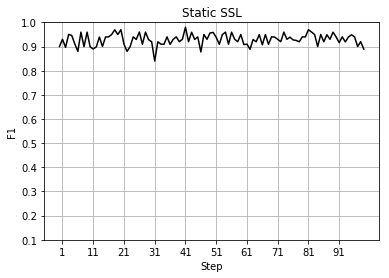




METHOD: Sliding lp as classifier


C:\Users\raul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time:  56.72828958024692
Average MCC:  0.960995247181
Average error: 1.8095
Average macro-F1: 0.9795713756517663
Average Accuracy:  98.1905
Standard Deviation:  2.28403913058
Variance:  5.21683475


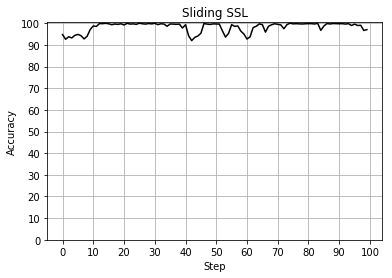

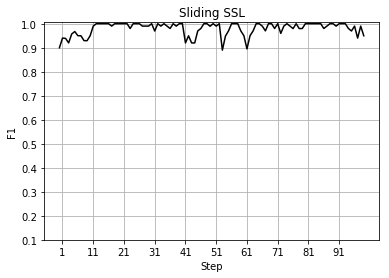




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  60.836310518518516
Average MCC:  0.965551874065
Average error: 1.494
Average macro-F1: 0.9819984906282367
Average Accuracy:  98.506
Standard Deviation:  2.04632939675
Variance:  4.187464


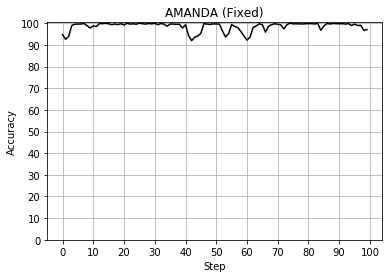

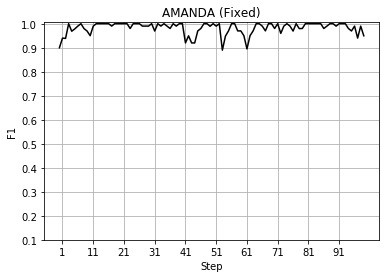




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
Execution time:  63.46702103703703
Average MCC:  0.919669647038
Average error: 3.894
Average macro-F1: 0.9583751704668343
Average Accuracy:  96.106
Standard Deviation:  1.01168868729
Variance:  1.023514


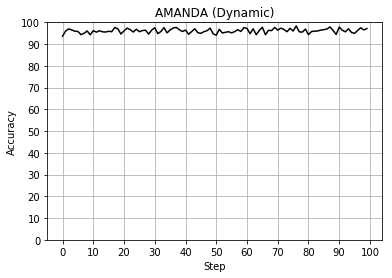

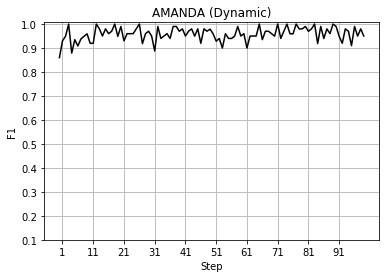




Method: SCARGC
Execution time:  63.46702103703703
Average MCC:  0.00512793893654
Average macro-F1: 0.34519972316560044
Average Accuracy:  98.2220590295
Standard Deviation: 

C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)
C:\Users\raul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 0.299603302375
Variance:  0.0897621387943


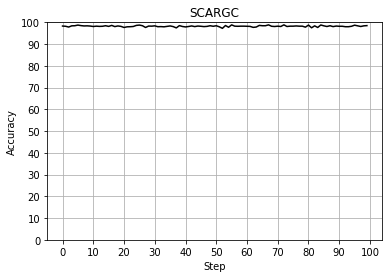

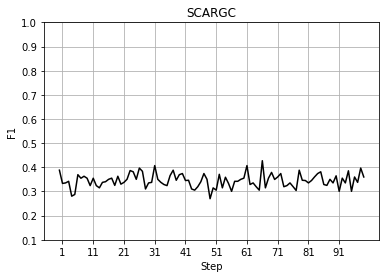

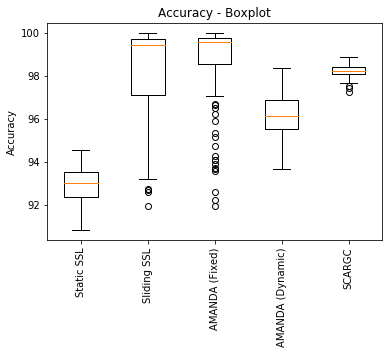

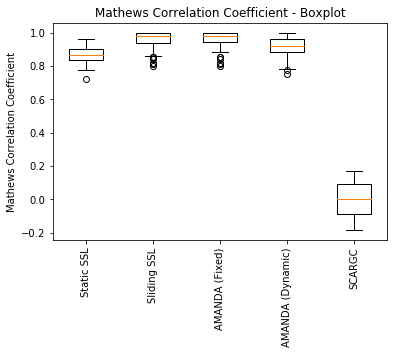

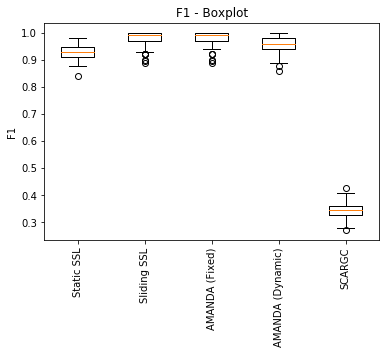

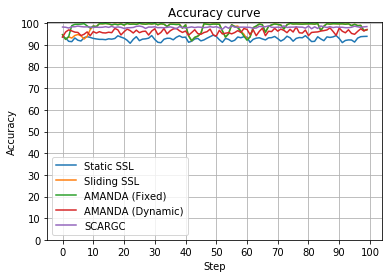

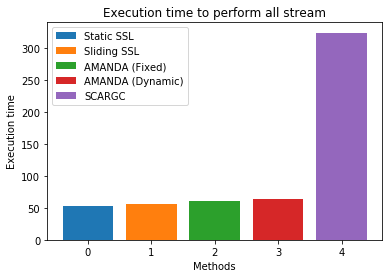

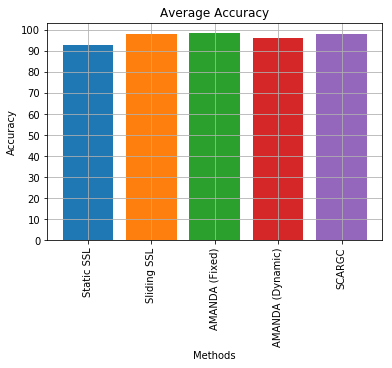

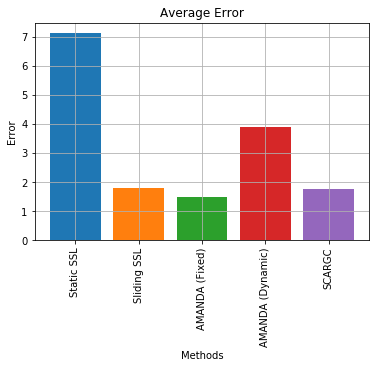

Error reduction: 5.72385315668
Error reduction: 6.06355888861
Error reduction: 3.47942653796
Error reduction: 5.75783345215


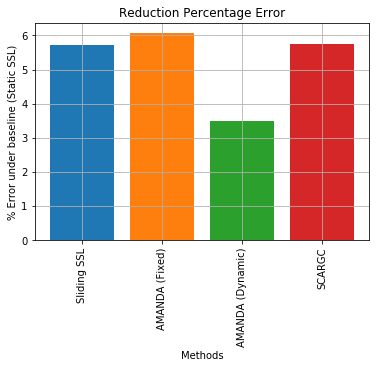

In [1]:
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[3])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import scargc_1NN
import numpy as np



class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K

        
def accSCARGC(path, sep, key, steps):
    resultsSCARGC_1, resultsSCARGC_2 = setup.loadSCARGCBoxplotResults(path, sep)
    results = resultsSCARGC_1[key]
    res = [ results[i::steps] for i in range(steps) ]
    arrAcc = []
    for i in range(steps):
        arrAcc.append(sum(res[i])/len(res[i])*100)
    return arrAcc, results


#only for binary classification
def labelSCARGC(resultsSCARGC, true_labels):
    predictions = []
    true_labels = np.array(true_labels)
    true_labels = true_labels.flatten()
    #print(true_labels)
    for i in range(len(true_labels)):
        if resultsSCARGC[i] == 1:
            predictions.append(true_labels[i])
        else:
            if true_labels[i] == 0:
                predictions.append(1)
            else:
                predictions.append(0)
    return predictions


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = 300
    isBatchMode = False # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadGEARS_2C_2D(path, sep)
    
    # Only 5% of initial labeled data - Extreme verification latency scenario
    labeledData = 50 #int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 4, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 4, clfName=sslClassifier)
    
    # Incremental SSL
    #experiments[2] = Experiment(incremental_LN, 5, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 4, 0.55, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    experiments[4] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier)

    # SCARGC 1NN (Python version)
    #experiments[5] = Experiment(scargc_1NN, 5) 
    arrAccSCARGC, predictionsSCARGC = accSCARGC(path, sep, 'GEARS_2C_2D', steps)
    #predictionsSCARGC = labelSCARGC(predictionsSCARGC, dataLabels[labeledData:])
    arrPredictionsSCARGC = [ predictionsSCARGC[i::steps] for i in range(steps) ]
    externalResults.append({"name":"SCARGC", "predictions":arrPredictionsSCARGC, "accuracies":arrAccSCARGC, "time":324.3381})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()